In [34]:
import numpy as np
import seaborn as sns
import dendropy
from dendropy.calculate import treecompare
import warnings
import matplotlib.pyplot as plt

import json
import os
from matplotlib.patches import Patch

import matplotlib.ticker as mticker
from matplotlib.font_manager import FontProperties
from sklearn.metrics import adjusted_rand_score

from src_python.cell_tree import CellTree
from src_python.utils import load_config_and_set_random_seed, path_len_dist, mut_count_distance

In [35]:
path = r"D:/PhD/SCITERNA/simulated_data"

n_c = 50
n_m = 500
n_tests = 100
round = 1

use_summary_statistics = False # Uses the summary files saved in the data_summary/ directory. If raw output files were generated, set to False

genotype_differences = {}
path_len_differences = {}
mut_count_differences = {}
rf_differences = {}
quartet_differences = {}
adjusted_rand_index = {}

metrics = [genotype_differences, path_len_differences, mut_count_differences, rf_differences, quartet_differences,adjusted_rand_index]
models = ["SCITE-RNA", "DENDRO", "SClineager", "PhylinSic"]
for metric in metrics:
    for model in models:
        metric[model] = {}

In [36]:
def to_newick(ct, node):
    if ct.isleaf(node):
        return f"{node}"
    children = ct.children(node)
    return "(" + ",".join(to_newick(ct, child) for child in children) + f"){node}"

In [37]:
param_sets = {
    'dropout': [0, 0.2, 0.4, 0.6],
    'overdispersion_Het': [3, 6, 10, 100],
    'overdispersion_Hom': [3, 6, 10, 100],
    'error_rate': [0.001, 0.01, 0.05, 0.1],
    'coverage_mean': [10, 30, 60, 100],
    'coverage_zero_inflation': [0, 0.2, 0.4, 0.6],
    'coverage_dispersion': [1, 2, 5, 10],
    "CNV_fraction": [0, 0.2, 0.5, 0.8],
    "homoplasy_fraction": [0, 0.1, 0.2, 0.5]
}
global_params = {}

if not use_summary_statistics:
    for param_name, param_values in param_sets.items():
        for param_value in param_values:
            param_str = f"{param_name}_{param_value}".replace('.', '_')
            base_path = os.path.join(path, f"{n_c}c{n_m}m_param_testing/{param_str}")
            print(param_str)

            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            rf_distances = []

            global_parameters = []

            for t in range(n_tests):
                genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{round}r{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                params_path = os.path.join(base_path, "sciterna", "sciterna_global_parameters", f"sciterna_global_parameters_{round}r{t}.txt")
                global_p = np.loadtxt(params_path, dtype=float)
                global_parameters.append(global_p)
                genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
                genotype_gt = np.loadtxt(genotype_path, dtype=str)

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{round}r{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_predicted = vectorized_map(genotype_pred)
                genotype_gt = vectorized_map(genotype_gt)
                unique_genotypes = np.unique(genotype_gt, axis=0)

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(difference)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            path_len_differences["SCITE-RNA"][param_str] = path_len_distances
            genotype_differences["SCITE-RNA"][param_str] = vaf_differences
            mut_count_differences["SCITE-RNA"][param_str] = mut_count_distances
            rf_differences["SCITE-RNA"][param_str] = rf_distances
            global_params[param_str] = global_parameters

            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

dropout_0
1.965330612244898  mean path length distance
0.0246072  mean abs difference of vafs predicted
10.213208163265307  mean mutation count distance
64.9  mean Robinson-Foulds distance
dropout_0_2
2.43854693877551  mean path length distance
0.0316416  mean abs difference of vafs predicted
12.192669387755105  mean mutation count distance
77.02  mean Robinson-Foulds distance
dropout_0_4
2.9042367346938778  mean path length distance
0.0386566  mean abs difference of vafs predicted
14.969738775510205  mean mutation count distance
83.58  mean Robinson-Foulds distance
dropout_0_6
3.2364653061224486  mean path length distance
0.04515339999999999  mean abs difference of vafs predicted
18.202897959183673  mean mutation count distance
88.04  mean Robinson-Foulds distance
overdispersion_Het_3
2.6784734693877543  mean path length distance
0.0351708  mean abs difference of vafs predicted
13.518236734693875  mean mutation count distance
81.64  mean Robinson-Foulds distance
overdispersion_Het_6
2

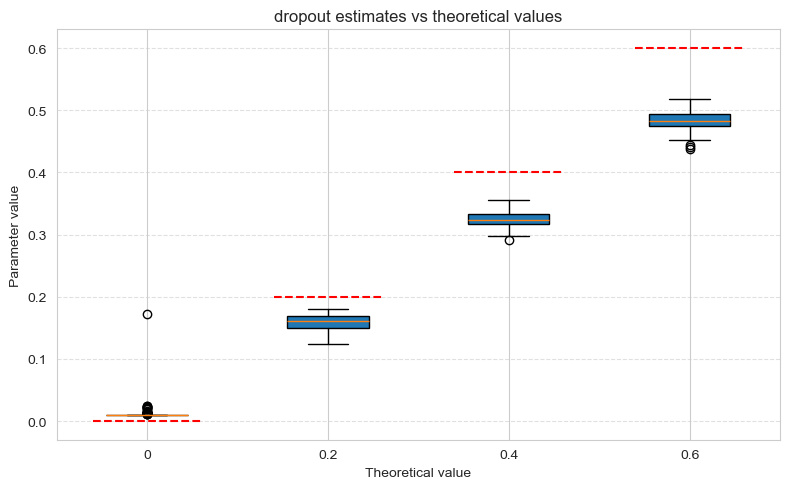

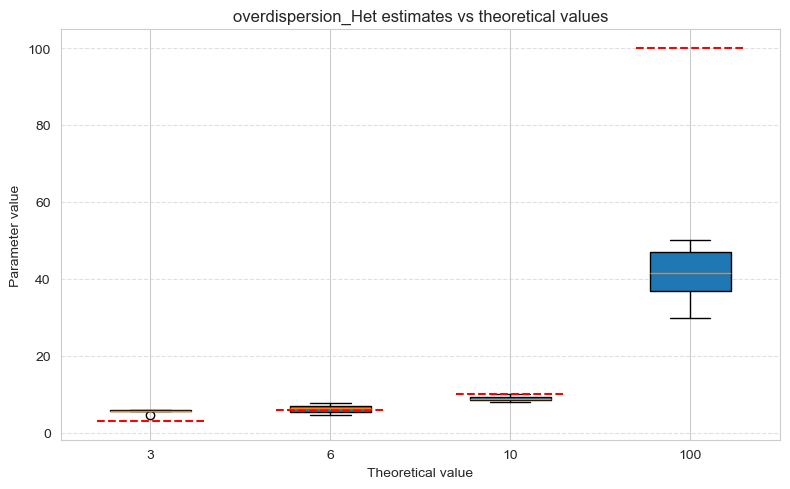

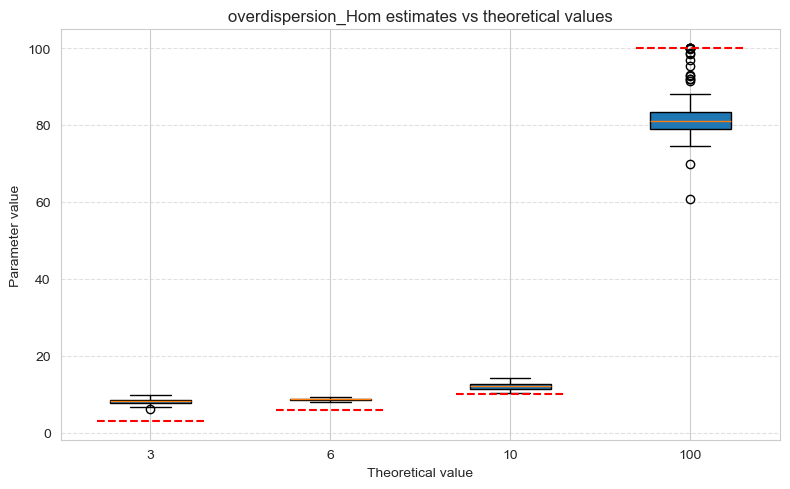

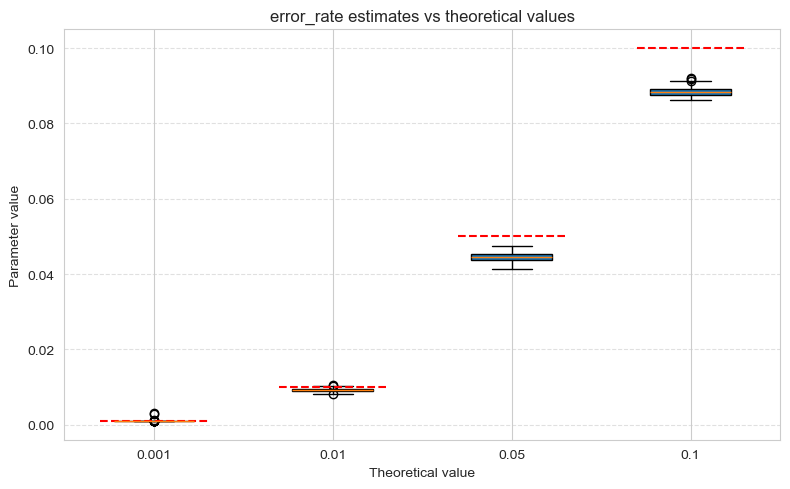

In [38]:
param_names = ["dropout", "overdispersion_Hom", "error_rate", "overdispersion_Het"]

for param_name, param_values in param_sets.items():
    if param_name not in param_names:
        continue
    plt.figure(figsize=(8, 5))

    all_estimates = []
    all_theoretical = []
    labels = []

    # Collect estimates for each parameter value
    for val in param_values:
        # Build the string format in param_str style
        val_str = str(val).replace('.', '_')
        param_str_base = f"{param_name}_{val_str}"

        estimates_for_val = []
        arrs = global_params[param_str_base]  # list of arrays
        # Extract the correct index for this parameter
        # Assuming param order matches param_sets order
        if param_name == 'dropout':
            idx = 0
        elif param_name == 'overdispersion_Hom':
            idx = 1
        elif param_name == 'error_rate':
            idx = 2
        elif param_name == 'overdispersion_Het':
            idx = 3
        else:
            continue

        for arr in arrs:
            estimates_for_val.append(arr[idx])

        all_estimates.append(estimates_for_val)
        # theoretical value from the param string
        theoretical_val = float(str(val).replace('_', '.'))
        all_theoretical.append(theoretical_val)
        labels.append(str(val))

    # Plot boxplots
    bp = plt.boxplot(all_estimates, positions=range(len(labels)), patch_artist=True)

    # Plot horizontal lines for theoretical values
    for i, theo in enumerate(all_theoretical):
        plt.plot([i-0.3, i+0.3], [theo, theo], color='red', linestyle='--', linewidth=1.5)

    plt.xticks(range(len(labels)), labels)
    plt.title(f"{param_name} estimates vs theoretical values")
    plt.ylabel("Parameter value")
    plt.xlabel("Theoretical value")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [39]:
if not use_summary_statistics:
    for param_name, param_values in param_sets.items():
        for param_value in param_values:
            param_str = f"{param_name}_{param_value}".replace('.', '_')
            base_path = os.path.join(path, f"{n_c}c{n_m}m_param_testing/{param_str}")
            print(param_str)

            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            rf_distances = []

            for t in range(n_tests):
                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "dendro", "dendro_clones", f"dendro_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                dendro_parent_vec = np.loadtxt(os.path.join(base_path, "dendro", "dendro_parent_vec", f"dendro_parent_vec_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_dendro = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_dendro.use_parent_vec(dendro_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_dendro))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_dendro, ct_dendro.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            path_len_differences["DENDRO"][param_str] = path_len_distances
            genotype_differences["DENDRO"][param_str] = vaf_differences
            mut_count_differences["DENDRO"][param_str] = mut_count_distances
            rf_differences["DENDRO"][param_str] = rf_distances

            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

dropout_0
4.834955102040817  mean path length distance
0.05940959999999999  mean abs difference of vafs predicted
3.949386372745491  mean mutation count distance
92.76  mean Robinson-Foulds distance
dropout_0_2
4.831265306122448  mean path length distance
0.0676996  mean abs difference of vafs predicted
4.513243286573147  mean mutation count distance
92.88  mean Robinson-Foulds distance
dropout_0_4
4.890546938775511  mean path length distance
0.0767564  mean abs difference of vafs predicted
5.209326573146293  mean mutation count distance
93.3  mean Robinson-Foulds distance
dropout_0_6
4.742465306122448  mean path length distance
0.0844368  mean abs difference of vafs predicted
5.741481042084168  mean mutation count distance
93.28  mean Robinson-Foulds distance
overdispersion_Het_3
4.770538775510205  mean path length distance
0.07440440000000001  mean abs difference of vafs predicted
5.019701723446894  mean mutation count distance
92.8  mean Robinson-Foulds distance
overdispersion_Het_6

FileNotFoundError: D:/PhD/SCITERNA/simulated_data\50c500m_param_testing/CNV_fraction_0_2\dendro\dendro_clones\dendro_clones_27.txt not found.

In [40]:
if not use_summary_statistics:
    for param_name, param_values in param_sets.items():
        for param_value in param_values:
            param_str = f"{param_name}_{param_value}".replace('.', '_')
            base_path = os.path.join(path, f"{n_c}c{n_m}m_param_testing/{param_str}")
            print(param_str)

            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            rf_distances = []

            for t in range(n_tests):
                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T
                vaf_predicted = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_vaf", f"sclineager_vaf_{t}.txt"), dtype=float).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sclineager", "sclineager_clones", f"sclineager_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sclineager_parent_vec = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                genotype_predicted = np.round(vaf_predicted * 2) / 2
                if genotype_predicted.shape != genotype_gt.shape:
                    print("Cells or mutations were filtered out")
                    continue
                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_sclineager = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sclineager.use_parent_vec(sclineager_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sclineager))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sclineager, ct_sclineager.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            path_len_differences["SClineager"][param_str] = path_len_distances
            genotype_differences["SClineager"][param_str] = vaf_differences
            mut_count_differences["SClineager"][param_str] = mut_count_distances
            rf_differences["SClineager"][param_str] = rf_distances

            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

dropout_0
Cells or mutations were filtered out
Cells or mutations were filtered out
4.73856726364015  mean path length distance
0.055216938775510205  mean abs difference of vafs predicted
3.875014355241095  mean mutation count distance
92.65306122448979  mean Robinson-Foulds distance
dropout_0_2
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
4.772833999579213  mean path length distance
0.0687420618556701  mean abs difference of vafs predicted
5.010649422556453  mean mutation count distance
92.80412371134021  mean Robinson-Foulds distance
dropout_0_4
Cells or mutations were filtered out
4.848938363224077  mean path length distance
0.0827680808080808  mean abs difference of vafs predicted
6.169366612011902  mean mutation count distance
93.11111111111111  mean Robinson-Foulds distance
dropout_0_6
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations w

C:\Users\Norio\anaconda3\envs\RNA\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Norio\anaconda3\envs\RNA\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Norio\AppData\Local\Temp\ipykernel_28172\3309980964.py:63: RuntimeWarning: Mean of empty slice
  print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")


Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
C

FileNotFoundError: D:/PhD/SCITERNA/simulated_data\50c500m_param_testing/CNV_fraction_0_2\sclineager\sclineager_vaf\sclineager_vaf_31.txt not found.

In [41]:
if not use_summary_statistics:
    for param_name, param_values in param_sets.items():
        for param_value in param_values:
            param_str = f"{param_name}_{param_value}".replace('.', '_')
            base_path = os.path.join(path, f"{n_c}c{n_m}m_param_testing/{param_str}")
            print(param_str)

            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            rf_distances = []

            for t in range(n_tests):
                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if not os.path.exists(os.path.join(base_path, "phylinsic", "phylinsic_parent_vec", f"phylinsic_parent_vec_{t}.txt")) or not os.path.exists(os.path.join(base_path, "phylinsic", "phylinsic_genotype", f"phylinsic_genotype_{t}.txt")):
                    print("PhylinSic parent vector file not found, skipping this test")
                    continue
                genotype_predicted = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_genotype", f"phylinsic_genotype_{t}.txt"), dtype=str)[1:]

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                phylinsic_parent_vec = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_parent_vec", f"phylinsic_parent_vec_{t}.txt"), dtype=int)


                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)
                genotype_predicted = vectorized_map(genotype_predicted)

                if genotype_predicted.shape != genotype_gt.shape:
                    print("Cells or mutations were filtered out")
                    continue

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_phylinsic = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_phylinsic.use_parent_vec(phylinsic_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_phylinsic))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_phylinsic, ct_phylinsic.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))


            path_len_differences["PhylinSic"][param_str] = path_len_distances
            genotype_differences["PhylinSic"][param_str] = vaf_differences
            mut_count_differences["PhylinSic"][param_str] = mut_count_distances
            rf_differences["PhylinSic"][param_str] = rf_distances

            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

dropout_0
5.0936  mean path length distance
0.0744018  mean abs difference of vafs predicted
4.1489704208416835  mean mutation count distance
93.6  mean Robinson-Foulds distance
dropout_0_2
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, ski

C:\Users\Norio\AppData\Local\Temp\ipykernel_28172\1278326504.py:63: RuntimeWarning: Mean of empty slice
  print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")


5.134800000000001  mean path length distance
0.08319739999999999  mean abs difference of vafs predicted
6.1377935070140275  mean mutation count distance
93.76  mean Robinson-Foulds distance
coverage_dispersion_5
4.777069387755102  mean path length distance
0.08824560000000002  mean abs difference of vafs predicted
5.626504609218436  mean mutation count distance
93.66  mean Robinson-Foulds distance
coverage_dispersion_10
4.882497959183674  mean path length distance
0.11717940000000002  mean abs difference of vafs predicted
7.826186372745492  mean mutation count distance
93.54  mean Robinson-Foulds distance
CNV_fraction_0
3.768269387755103  mean path length distance
0.07901459999999999  mean abs difference of vafs predicted
4.626756072144289  mean mutation count distance
90.24  mean Robinson-Foulds distance
CNV_fraction_0_2
3.9734612244897956  mean path length distance
0.08732220000000002  mean abs difference of vafs predicted
4.587785731462926  mean mutation count distance
90.5  mean Ro

In [42]:
import json
from pathlib import Path

# Example: your existing dictionaries
# path_len_differences, genotype_differences, mut_count_differences, rf_differences

outdir = Path(r"D:\PhD\SCITERNA\simulated_data/json_outputs")
outdir.mkdir(parents=True, exist_ok=True)

# Save each dictionary as a JSON file
with open(outdir / "path_len_differences.json", "w") as f:
    json.dump(path_len_differences, f, indent=2)

with open(outdir / "genotype_differences.json", "w") as f:
    json.dump(genotype_differences, f, indent=2)

with open(outdir / "mut_count_differences.json", "w") as f:
    json.dump(mut_count_differences, f, indent=2)

with open(outdir / "rf_differences.json", "w") as f:
    json.dump(rf_differences, f, indent=2)

print("✅ Saved all difference dictionaries as JSON files in", outdir)

✅ Saved all difference dictionaries as JSON files in D:\PhD\SCITERNA\simulated_data\json_outputs


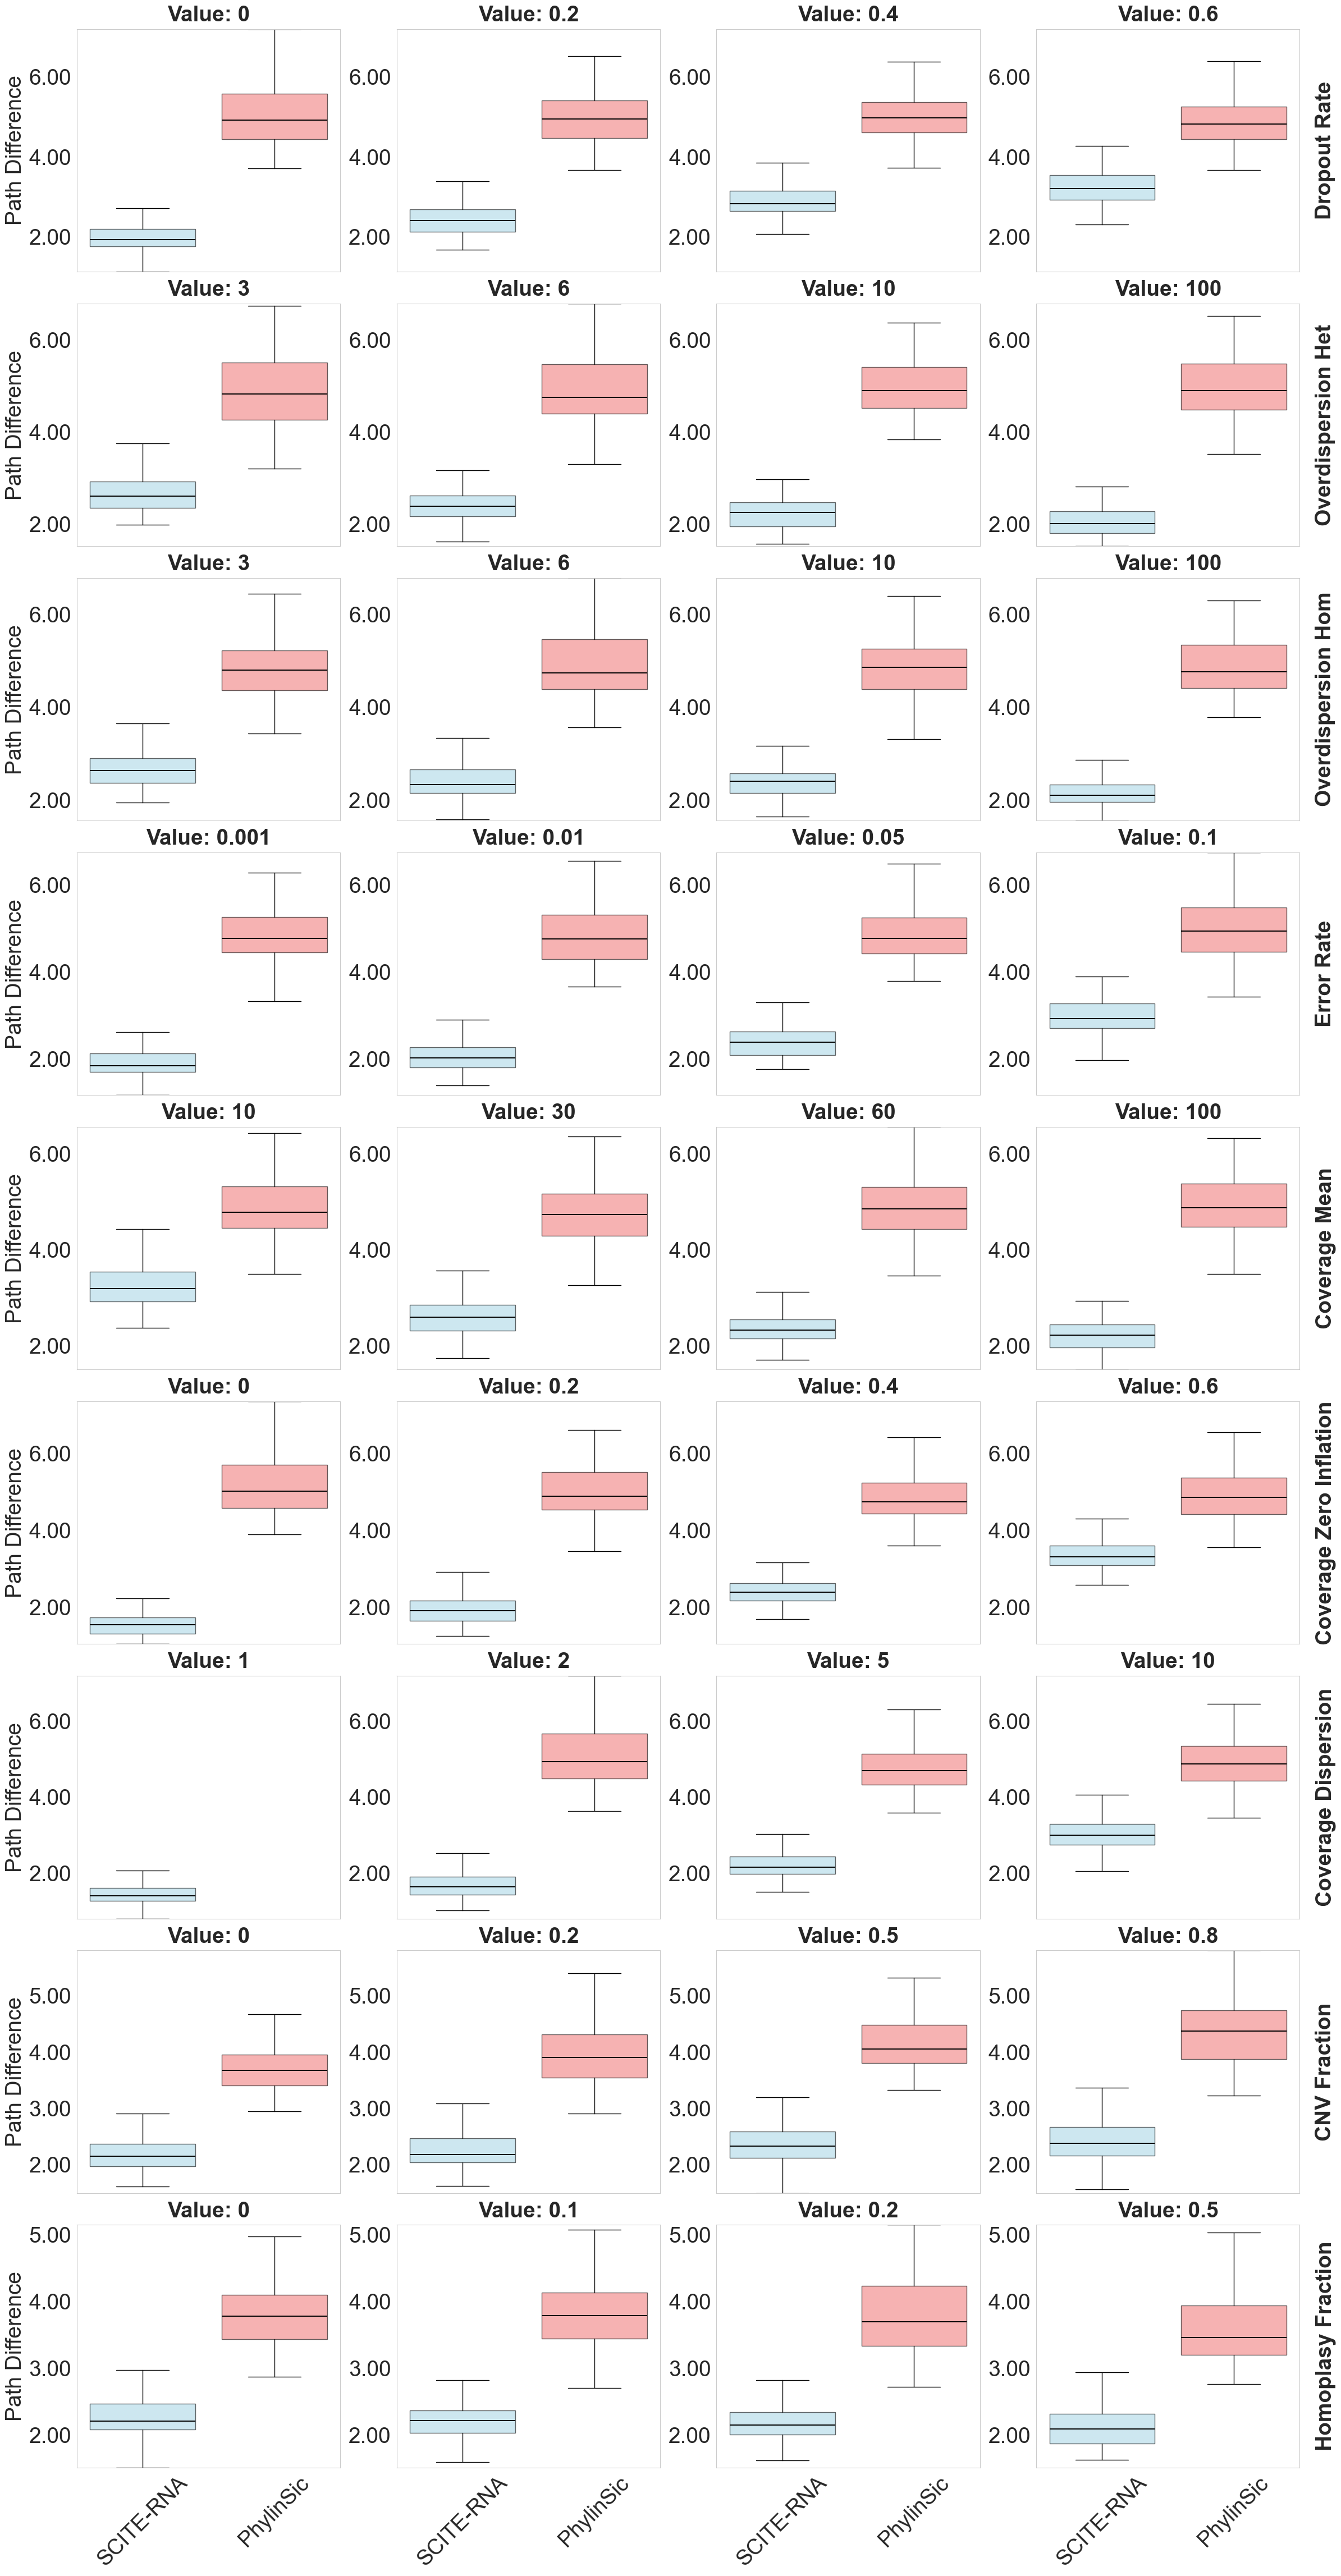

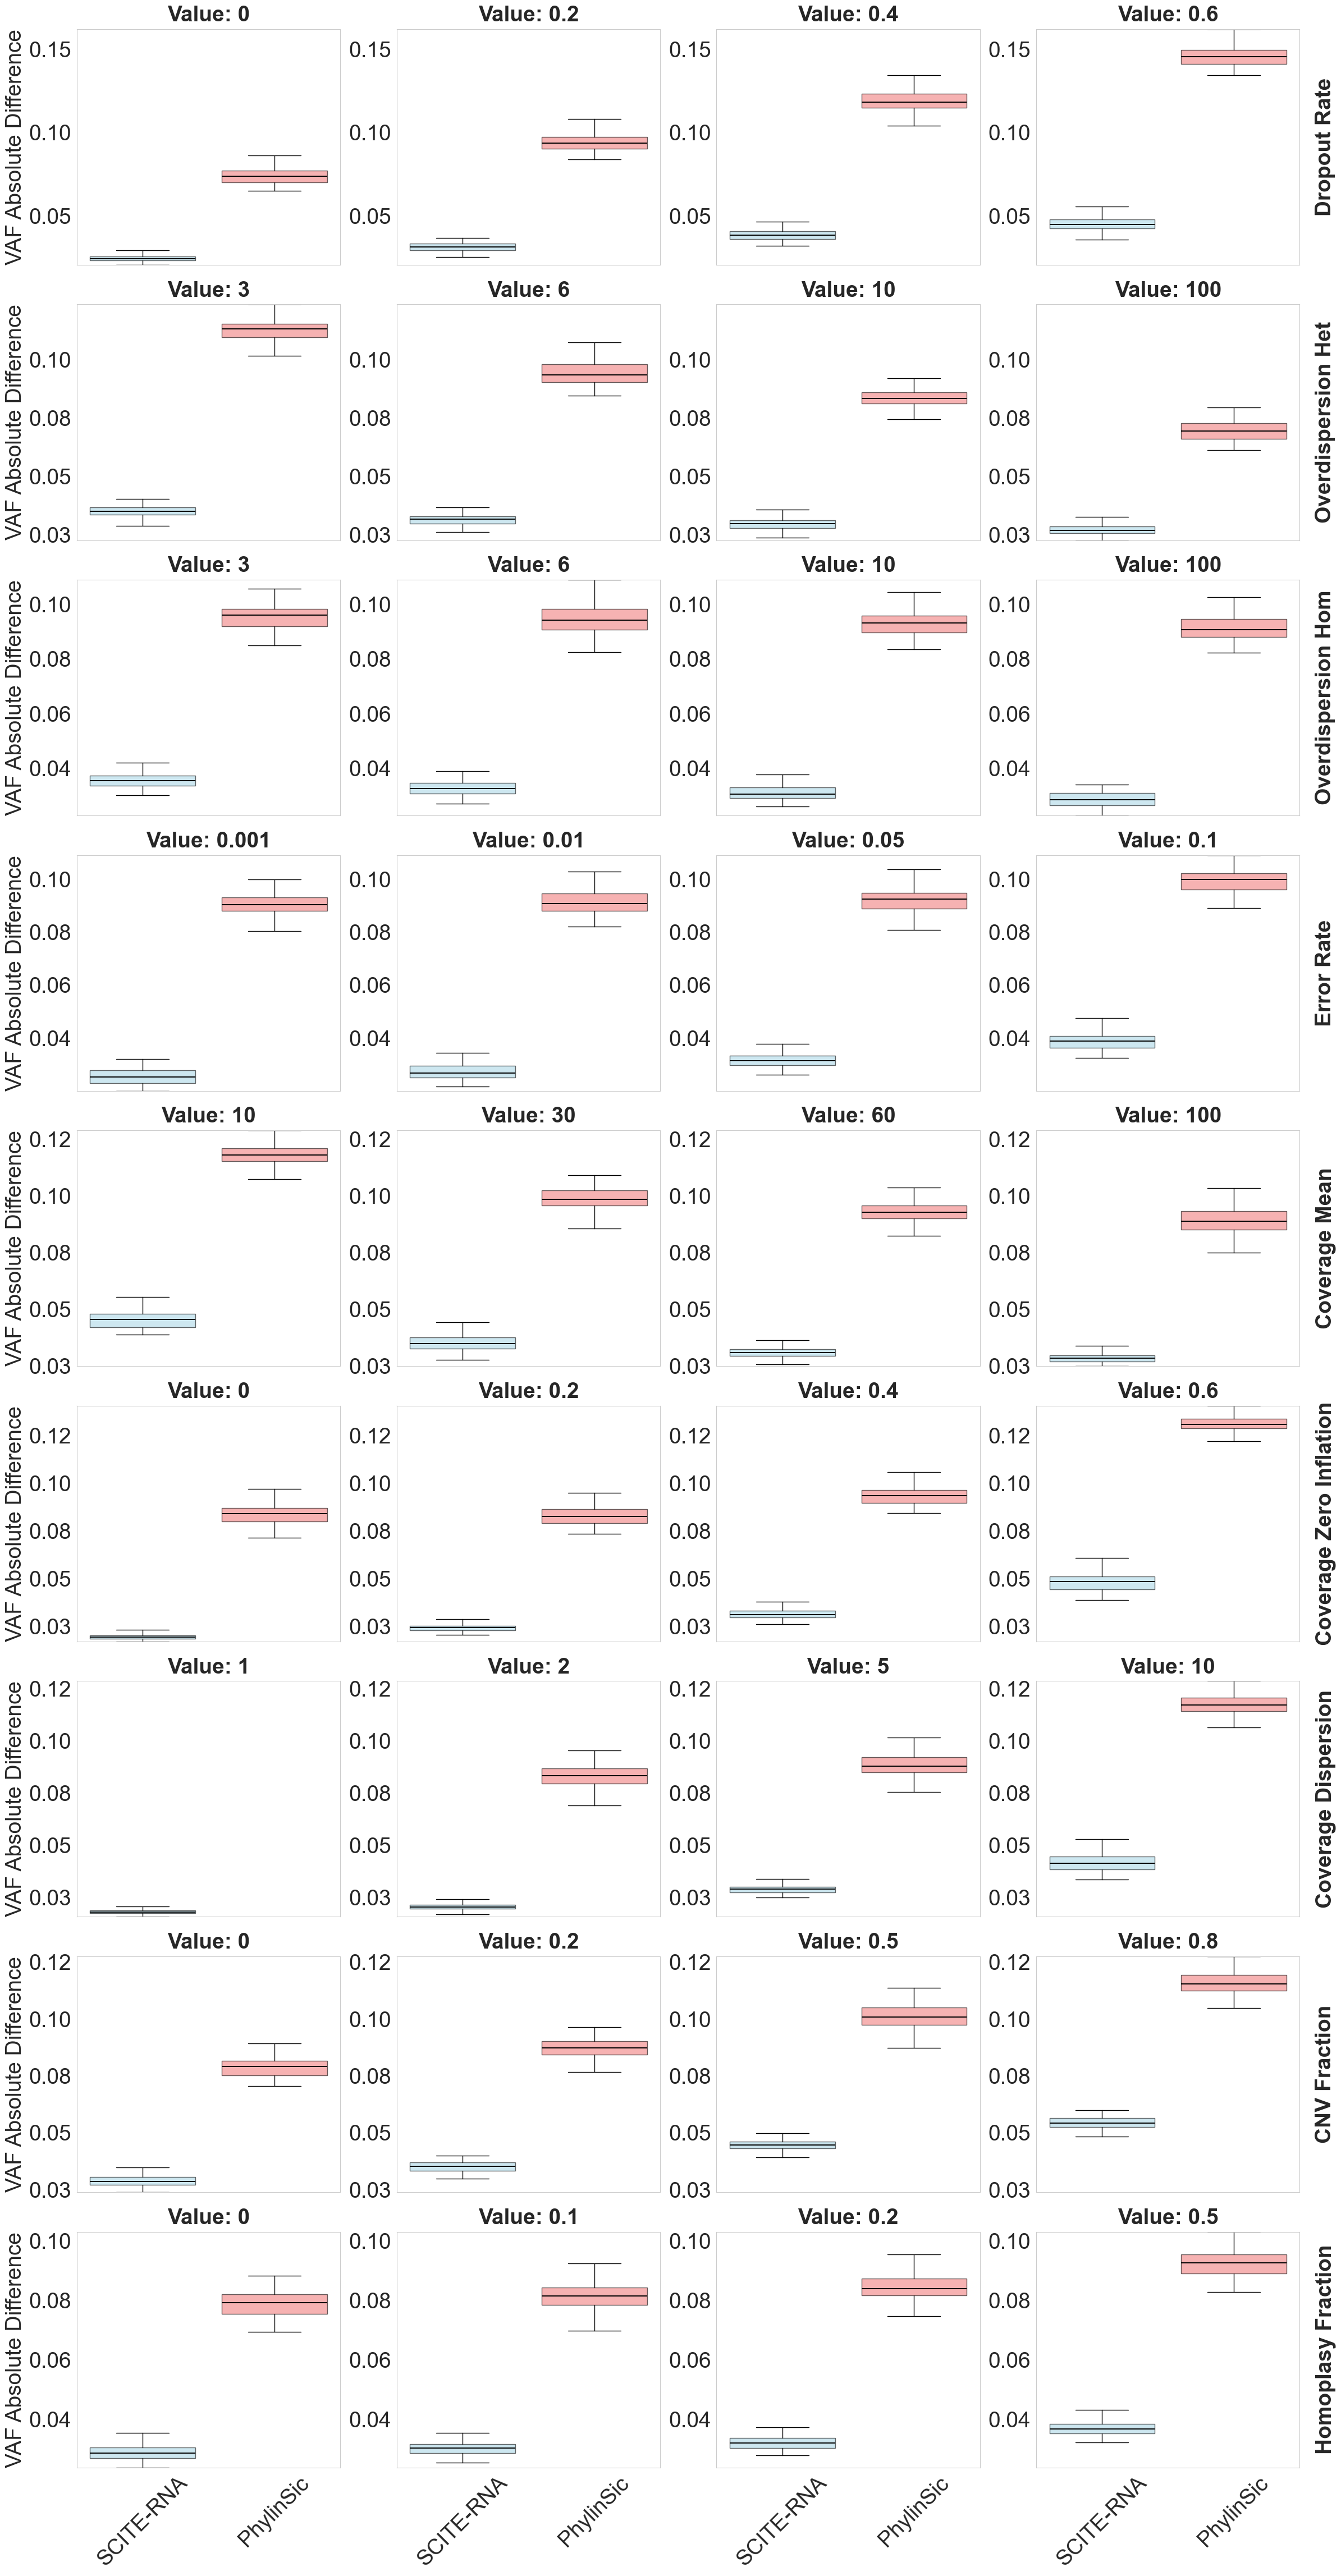

KeyError: 'CNV_fraction_0_2'

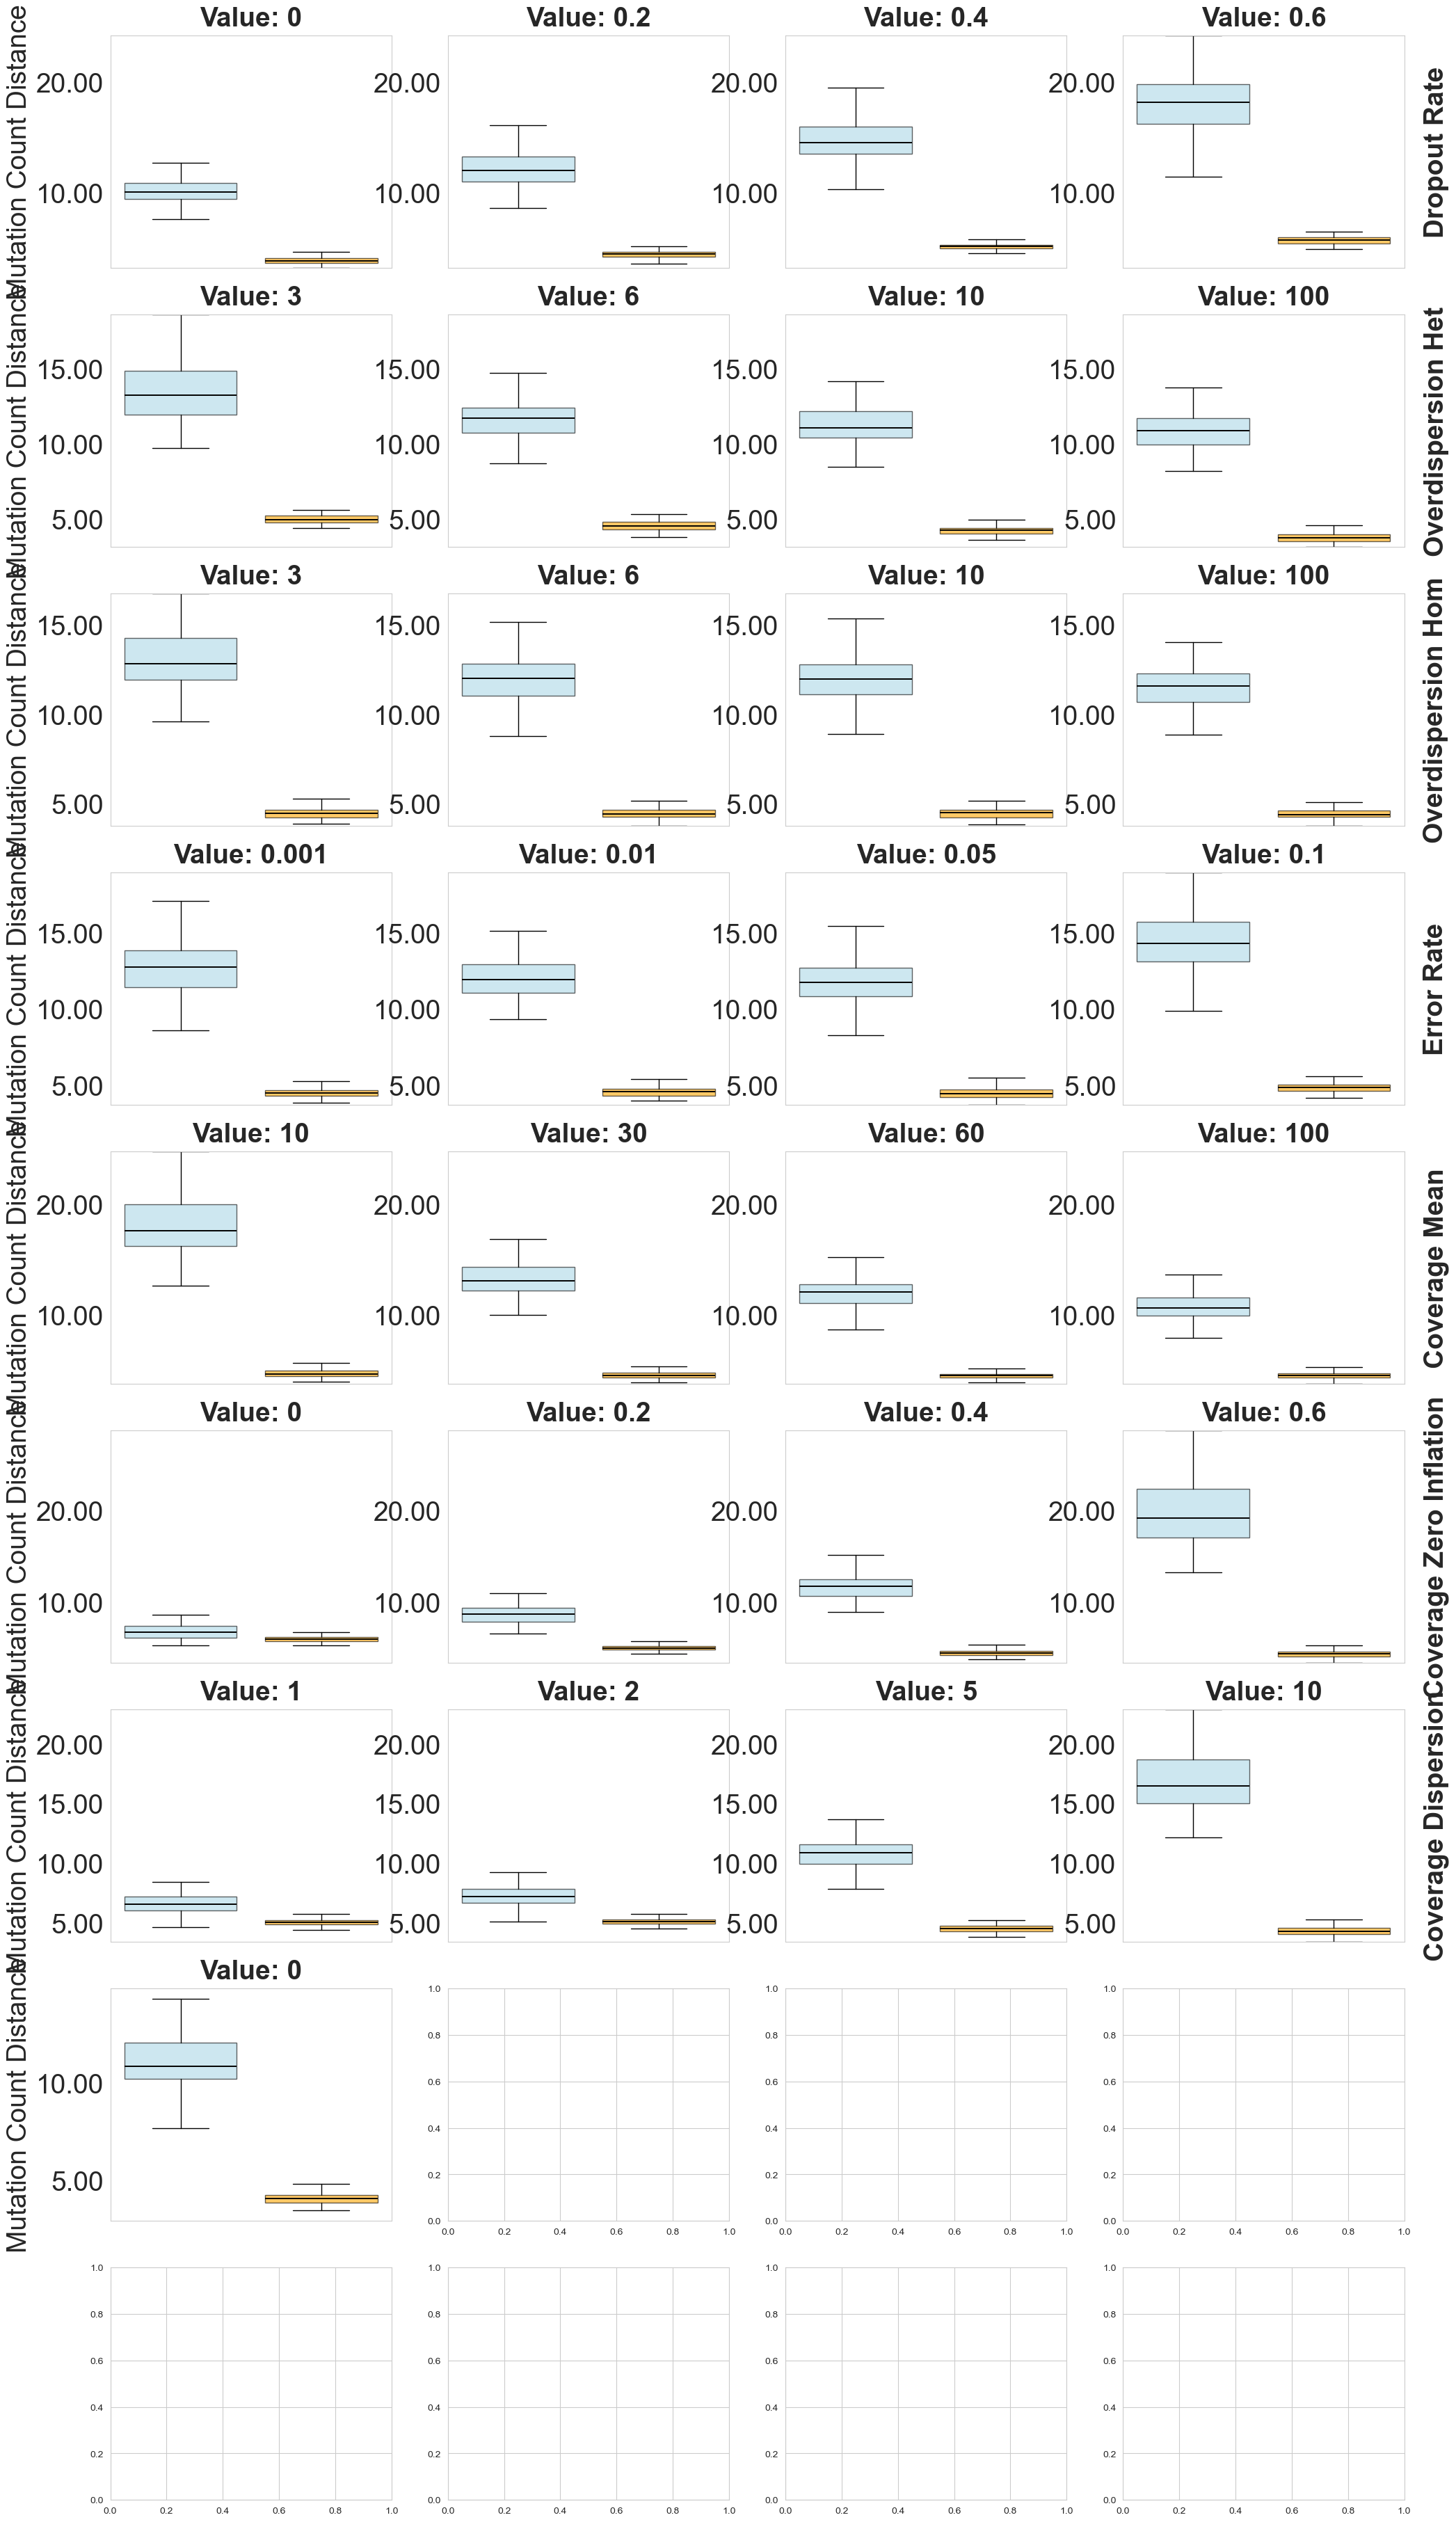

In [44]:
def plot_parameter_results(metric = "Path Difference", data={}, models=["SCITE-RNA", "DENDRO"]):

    rows = len(param_sets)
    cols = 4

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows + 1), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors_dict = {"SCITE-RNA": "lightblue",
        "SClineager": "lightgreen",
        "DENDRO": "orange",
        "PhylinSic":  "lightcoral"
    }
    colors = [colors_dict[model] for model in models]

    param_to_name = {
        'dropout': "Dropout Rate",
        'overdispersion_Het': "Overdispersion Het",
        'overdispersion_Hom': "Overdispersion Hom",
        'error_rate': "Error Rate",
        'coverage_mean': "Coverage Mean",
        'coverage_zero_inflation': "Coverage Zero Inflation",
        'coverage_dispersion': "Coverage Dispersion",
        "CNV_fraction": "CNV Fraction",
        "homoplasy_fraction": "Homoplasy Fraction"
    }

    alpha_value = 0.6

    title_size = 28
    label_size = 28
    tick_size = 28
    box_width = 1.4
    boxplot_widths = 0.8

    parameters = param_sets.keys()

    for row_idx, parameter in enumerate(parameters):
        row_whiskers = []
        column_values = param_sets[parameter]

        for col_idx, param_value in enumerate(column_values):
            sample_key = f"{parameter}_{param_value}".replace('.', '_')
            all_samples = [data[model][sample_key] for model in models]

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            ax.set_title(f"Value: {param_value}", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(metric, fontsize=label_size)
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(param_to_name[parameter],
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Apply uniform y-limits across each row
        combined = np.concatenate(row_whiskers)
        ymin, ymax = np.nanmin(combined), np.nanmax(combined)
        # yrange = ymax - ymin
        # ymin = 0
        # ymax = min(ymax*1.05 * yrange, 1000)

        for col_idx in range(cols):
            axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()

    # plt.savefig("../data/results/figures/Figure_Path_VAF.pdf")
    plt.show()

plot_parameter_results("Path Difference", path_len_differences, models=["SCITE-RNA", "PhylinSic"])
plot_parameter_results("VAF Absolute Difference", genotype_differences, models=["SCITE-RNA", "PhylinSic"])
plot_parameter_results("Mutation Count Distance", mut_count_differences, models=["SCITE-RNA", "DENDRO"])
plot_parameter_results("Robinson-Foulds Distance", rf_differences, models=["SCITE-RNA", "DENDRO"])

In [66]:
n_rounds = 25
vafs = {}
plds = {}
mcds = {}
rfs = {}

global_params = {}

if not use_summary_statistics:
    for r in range(n_rounds):
        base_path = os.path.join(path, f"{n_c}c{n_m}m")

        vaf_differences = []
        path_len_distances = []
        mut_count_distances = []
        rf_distances = []
        g_params = []

        for t in range(n_tests):
            genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{r}r{t}.txt")
            genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
            params_path = os.path.join(base_path, "sciterna", "sciterna_global_parameters", f"sciterna_global_parameters_{r}r{t}.txt")
            genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
            genotype_gt = np.loadtxt(genotype_path, dtype=str)
            global_p = np.loadtxt(params_path, dtype=float)
            g_params.append(global_p)

            true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
            sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{r}r{t}.txt"), dtype=int)

            mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
            vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
            genotype_predicted = vectorized_map(genotype_pred)
            genotype_gt = vectorized_map(genotype_gt)
            unique_genotypes = np.unique(genotype_gt, axis=0)

            difference = np.mean(np.abs(genotype_predicted - genotype_gt))
            vaf_differences.append(difference)

            ct_gt = CellTree(n_c)
            ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

            ct_gt.use_parent_vec(true_parent_vec)
            ct_sciterna.use_parent_vec(sciterna_parent_vec)

            path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
            mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

            newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
            newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
            taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
            tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
            tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
            rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

        plds[r] = path_len_distances
        vafs[r] = vaf_differences
        mcds[r] = mut_count_distances
        rfs[r] = rf_distances
        global_params[r] = g_params

        print(np.mean(path_len_distances), " mean path length distance")
        print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
        print(np.mean(mut_count_distances), " mean mutation count distance")
        print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

2.4141795918367346  mean path length distance
0.03174459999999999  mean abs difference of vafs predicted
11.378555102040815  mean mutation count distance
75.8  mean Robinson-Foulds distance
2.3880163265306122  mean path length distance
0.030648000000000005  mean abs difference of vafs predicted
11.563787755102041  mean mutation count distance
75.68  mean Robinson-Foulds distance
2.4012000000000002  mean path length distance
0.030756799999999997  mean abs difference of vafs predicted
11.459444897959184  mean mutation count distance
75.6  mean Robinson-Foulds distance
2.374873469387755  mean path length distance
0.0307578  mean abs difference of vafs predicted
11.580220408163266  mean mutation count distance
75.56  mean Robinson-Foulds distance
2.386848979591837  mean path length distance
0.03065739999999999  mean abs difference of vafs predicted
11.527795918367346  mean mutation count distance
75.58  mean Robinson-Foulds distance
2.384391836734694  mean path length distance
0.0308088  m

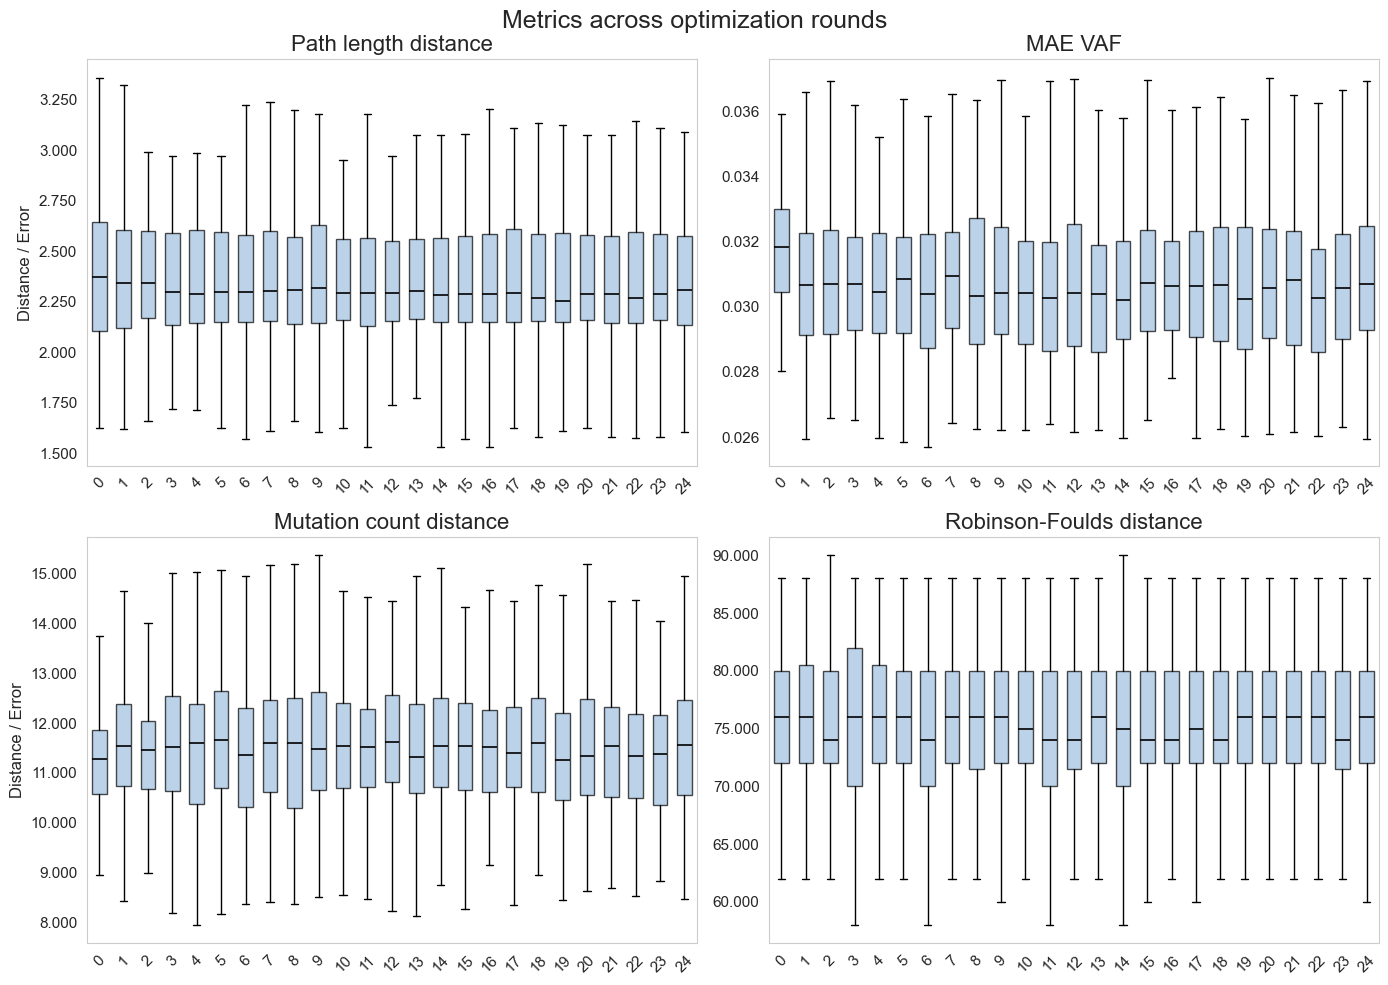

In [67]:
def plot_metrics_across_rounds(plds, vafs, mcds, rfs, n_rounds,
                               round_labels=None,
                               figsize=(14,10),
                               title_font=16,
                               tick_font=11,
                               ylabel_font=12,
                               save_path=None):

    def build_list(metric_dict):
        all_data = []
        present_rounds = []
        for r in range(n_rounds):
            vals = metric_dict.get(r, None)
            if vals is None:
                all_data.append([])   # matplotlib will handle empty lists
            else:
                # ensure numpy array and remove NaNs
                arr = np.asarray(vals, dtype=float)
                arr = arr[~np.isnan(arr)]
                all_data.append(arr if arr.size > 0 else [])
            present_rounds.append(r)
        return all_data

    data_pld = build_list(plds)
    data_vaf = build_list(vafs)
    data_mcd = build_list(mcds)
    data_rf  = build_list(rfs)

    if round_labels is None:
        round_labels = [str(r) for r in range(n_rounds)]

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    panel_info = [
        (data_pld, "Path length distance"),
        (data_vaf, "MAE VAF"),
        (data_mcd, "Mutation count distance"),
        (data_rf,  "Robinson-Foulds distance")
    ]

    for ax, (data, title) in zip(axes, panel_info):
        # Replace empty lists with small NaN arrays so boxplot receives constant-length list
        prepared = [d if (isinstance(d, np.ndarray) and d.size>0) or (isinstance(d, list) and len(d)>0) else np.array([np.nan]) for d in data]
        # Create boxplot
        bp = ax.boxplot(prepared, positions=np.arange(len(prepared)), patch_artist=True, widths=0.6, showfliers=False)
        # style
        for box in bp['boxes']:
            box.set(facecolor="#9fbfe0", alpha=0.7)
        for median in bp['medians']:
            median.set(color='black', linewidth=1.2)

        # If many rounds, rotate labels
        ax.set_xticks(np.arange(len(prepared)))
        ax.set_xticklabels(round_labels, rotation=45, fontsize=tick_font)
        ax.set_title(title, fontsize=title_font)
        ax.tick_params(axis='y', labelsize=tick_font)
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
        ax.grid(False)

        # Annotate rounds that had no data
        for i, d in enumerate(data):
            if (isinstance(d, np.ndarray) and d.size == 0) or (isinstance(d, list) and len(d) == 0):
                ax.text(i, 0.5*(ax.get_ylim()[0]+ax.get_ylim()[1]), "no data",
                        ha='center', va='center', color='gray', alpha=0.6, fontsize=9, rotation=90)

    # Y-axis labels: left column common labels
    axes[0].set_ylabel("Distance / Error", fontsize=ylabel_font)
    axes[2].set_ylabel("Distance / Error", fontsize=ylabel_font)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    fig.suptitle("Metrics across optimization rounds", fontsize=18)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    plt.show()

plot_metrics_across_rounds(plds, vafs, mcds, rfs, n_rounds)

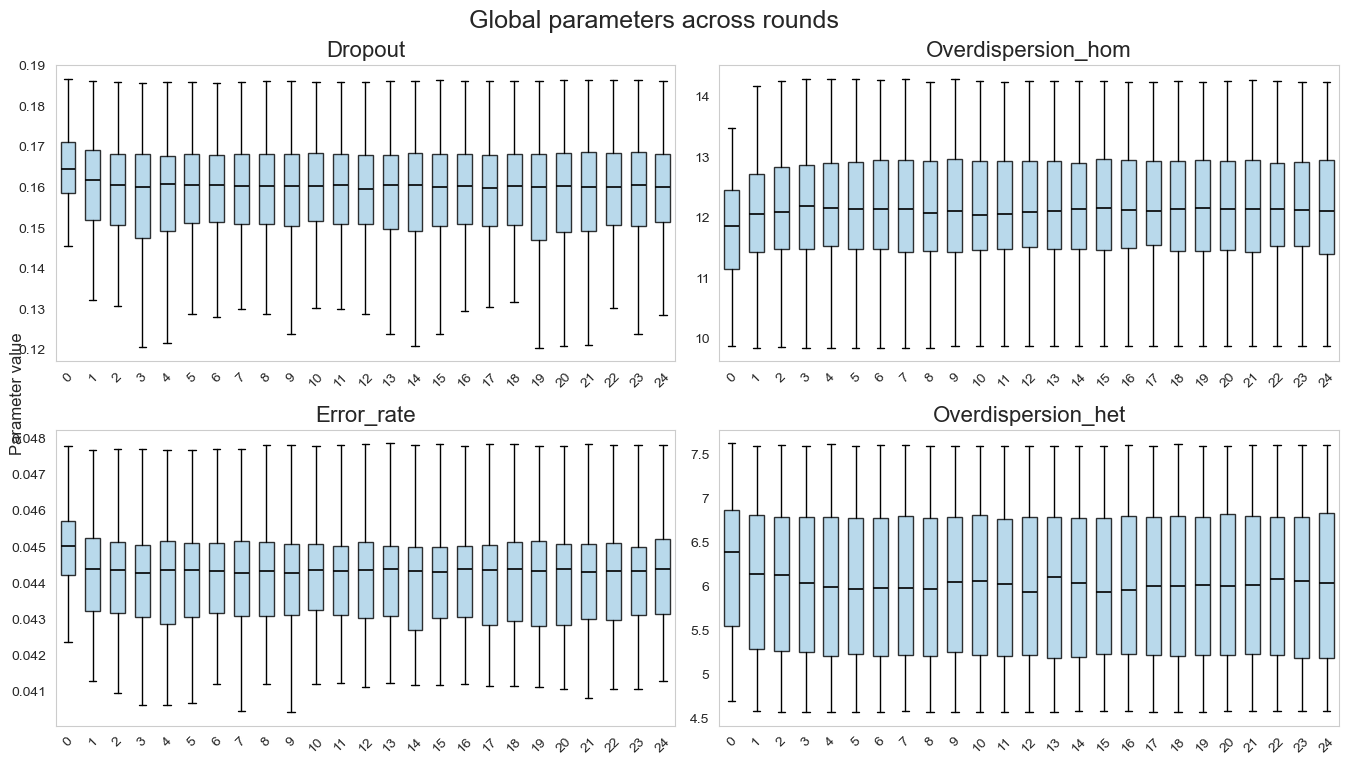

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_global_params_across_rounds(global_params, n_rounds,
                                     param_names=None,
                                     figsize=(14, 8),
                                     title_font=16,
                                     tick_font=10,
                                     ylabel_font=12,
                                     save_path=None):

    if param_names is None:
        param_names = ["Dropout", "Overdispersion_hom", "Error_rate", "Overdispersion_het"]
    assert len(param_names) == 4, "param_names must have four entries"

    # Build per-parameter, per-round lists
    # result[pi][r] -> 1d numpy array of values for parameter pi at round r (or empty array)
    result = [[None for _ in range(n_rounds)] for _ in range(4)]

    for r in range(n_rounds):
        vals = global_params.get(r, None)
        if vals is None:
            # leave as empty arrays
            for pi in range(4):
                result[pi][r] = np.array([], dtype=float)
            continue

        # vals is expected to be a list of arrays (one per test). Stack them if possible.
        try:
            stacked = np.vstack(vals)  # shape (n_tests, 4)
        except Exception:
            # fallback: try to convert elements individually
            arrs = []
            for v in vals:
                try:
                    arrs.append(np.asarray(v, dtype=float))
                except Exception:
                    pass
            if len(arrs) > 0:
                stacked = np.vstack(arrs)
            else:
                stacked = np.empty((0, 4), dtype=float)

        # Ensure second dimension is 4
        if stacked.ndim == 1:
            # single vector
            stacked = stacked.reshape(1, -1)
        if stacked.shape[1] < 4:
            # pad with NaNs if shape is unexpected
            padded = np.full((stacked.shape[0], 4), np.nan, dtype=float)
            padded[:, :stacked.shape[1]] = stacked
            stacked = padded
        elif stacked.shape[1] > 4:
            stacked = stacked[:, :4]

        for pi in range(4):
            col = stacked[:, pi]
            # remove NaNs
            col = col[~np.isnan(col)]
            result[pi][r] = col

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=figsize, squeeze=True)
    axes = axes.flatten()
    x_positions = np.arange(n_rounds)

    for pi in range(4):
        ax = axes[pi]
        param_label = param_names[pi]
        # Prepare data: boxplot wants list-like; replace empty arrays with np.array([np.nan]) so boxplot doesn't crash
        prepared = [arr if (isinstance(arr, np.ndarray) and arr.size > 0) else np.array([np.nan]) for arr in result[pi]]
        bp = ax.boxplot(prepared, positions=x_positions, patch_artist=True, widths=0.6, showfliers=False)

        # styling
        for box in bp['boxes']:
            box.set(facecolor="#a8d0e6", alpha=0.8)
        for median in bp['medians']:
            median.set(color='black', linewidth=1.2)

        ax.set_title(param_label, fontsize=title_font)
        ax.set_xticks(x_positions)
        ax.set_xticklabels([str(r) for r in range(n_rounds)], rotation=45, fontsize=tick_font)
        ax.tick_params(axis='y', labelsize=tick_font)
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4g'))
        ax.grid(False)

        # annotate missing rounds
        for i, arr in enumerate(result[pi]):
            if isinstance(arr, np.ndarray) and arr.size == 0:
                # place annotation near center of y
                ylim = ax.get_ylim()
                ymid = 0.5 * (ylim[0] + ylim[1])
                ax.text(i, ymid, "no data", ha='center', va='center', color='gray', alpha=0.6, fontsize=9, rotation=90)

    # shared Y-label
    fig.text(0.04, 0.5, "Parameter value", va='center', rotation='vertical', fontsize=ylabel_font)

    plt.tight_layout(rect=[0.03, 0.03, 1, 0.96])
    fig.suptitle("Global parameters across rounds", fontsize=18)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved global-params plot to {save_path}")
    plt.show()

plot_global_params_across_rounds(global_params, n_rounds)

In [ ]:
n_cells = [100, 5000, 1000]
n_mutations = [5000, 100, 1000]

for n_c, n_m in zip(n_cells, n_mutations):
    print(f"Cells: {n_c}, Mutations: {n_m}")
    base_path = os.path.join(path, f"{n_c}c{n_m}m")

    vaf_differences = []
    path_len_distances = []
    mut_count_distances = []
    rf_distances = []
    # g_params = [

    for t in range(n_tests):
        genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{round}r{t}.txt")
        genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
        params_path = os.path.join(base_path, "sciterna", "sciterna_global_parameters", f"sciterna_global_parameters_{round}r{t}.txt")
        genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
        genotype_gt = np.loadtxt(genotype_path, dtype=str)
        # global_p = np.loadtxt(params_path, dtype=float)
        # g_params.append(global_p)

        true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
        sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{round}r{t}.txt"), dtype=int)

        mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
        vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
        genotype_predicted = vectorized_map(genotype_pred)
        genotype_gt = vectorized_map(genotype_gt)
        unique_genotypes = np.unique(genotype_gt, axis=0)

        difference = np.mean(np.abs(genotype_predicted - genotype_gt))
        vaf_differences.append(difference)

        ct_gt = CellTree(n_c)
        ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

        ct_gt.use_parent_vec(true_parent_vec)
        ct_sciterna.use_parent_vec(sciterna_parent_vec)

        path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
        mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

        newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
        newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
        taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
        tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
        tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
        rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

    path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = path_len_distances
    genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = vaf_differences
    mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = mut_count_distances
    rf_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = rf_distances

    print(np.mean(path_len_distances), " mean path length distance")
    print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
    print(np.mean(mut_count_distances), " mean mutation count distance")
    print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

Cells: 100, Mutations: 5000
2.119923232323232  mean path length distance
0.014436280000000001  mean abs difference of vafs predicted
31.72834747474748  mean mutation count distance
81.18  mean Robinson-Foulds distance
Cells: 5000, Mutations: 100


In [ ]:

def plot_large_datasets(pathlen_data, vaf_data, clones, models=["SCITE-RNA", "SClineager", "DENDRO", "PhylinSic"]):

    n_c, n_m = 50, 500  # fixed cell and mutation counts
    rows = 2
    cols = len(clones)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows + 1), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["lightblue", "lightgreen", "orange", "lightcoral"]
    alpha_value = 0.6

    title_size = 28
    label_size = 28
    tick_size = 28
    box_width = 1.4
    boxplot_widths = 0.8

    plot_titles = ["Path Difference", "MAE VAF"]
    data_list = [pathlen_data, vaf_data]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            all_samples = [data[model][sample_key][clone] for model in models]

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("50 Clones", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Apply uniform y-limits across each row
        combined = np.concatenate(row_whiskers)
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin = 0
        ymax += 0.05 * yrange

        if np.isfinite(ymin):
            for col_idx in range(cols):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/Figure_Path_VAF.pdf")
    plt.show()

plot_combined_vaf_pathlength(path_len_differences, genotype_differences, ["5", "10", "20", ""])